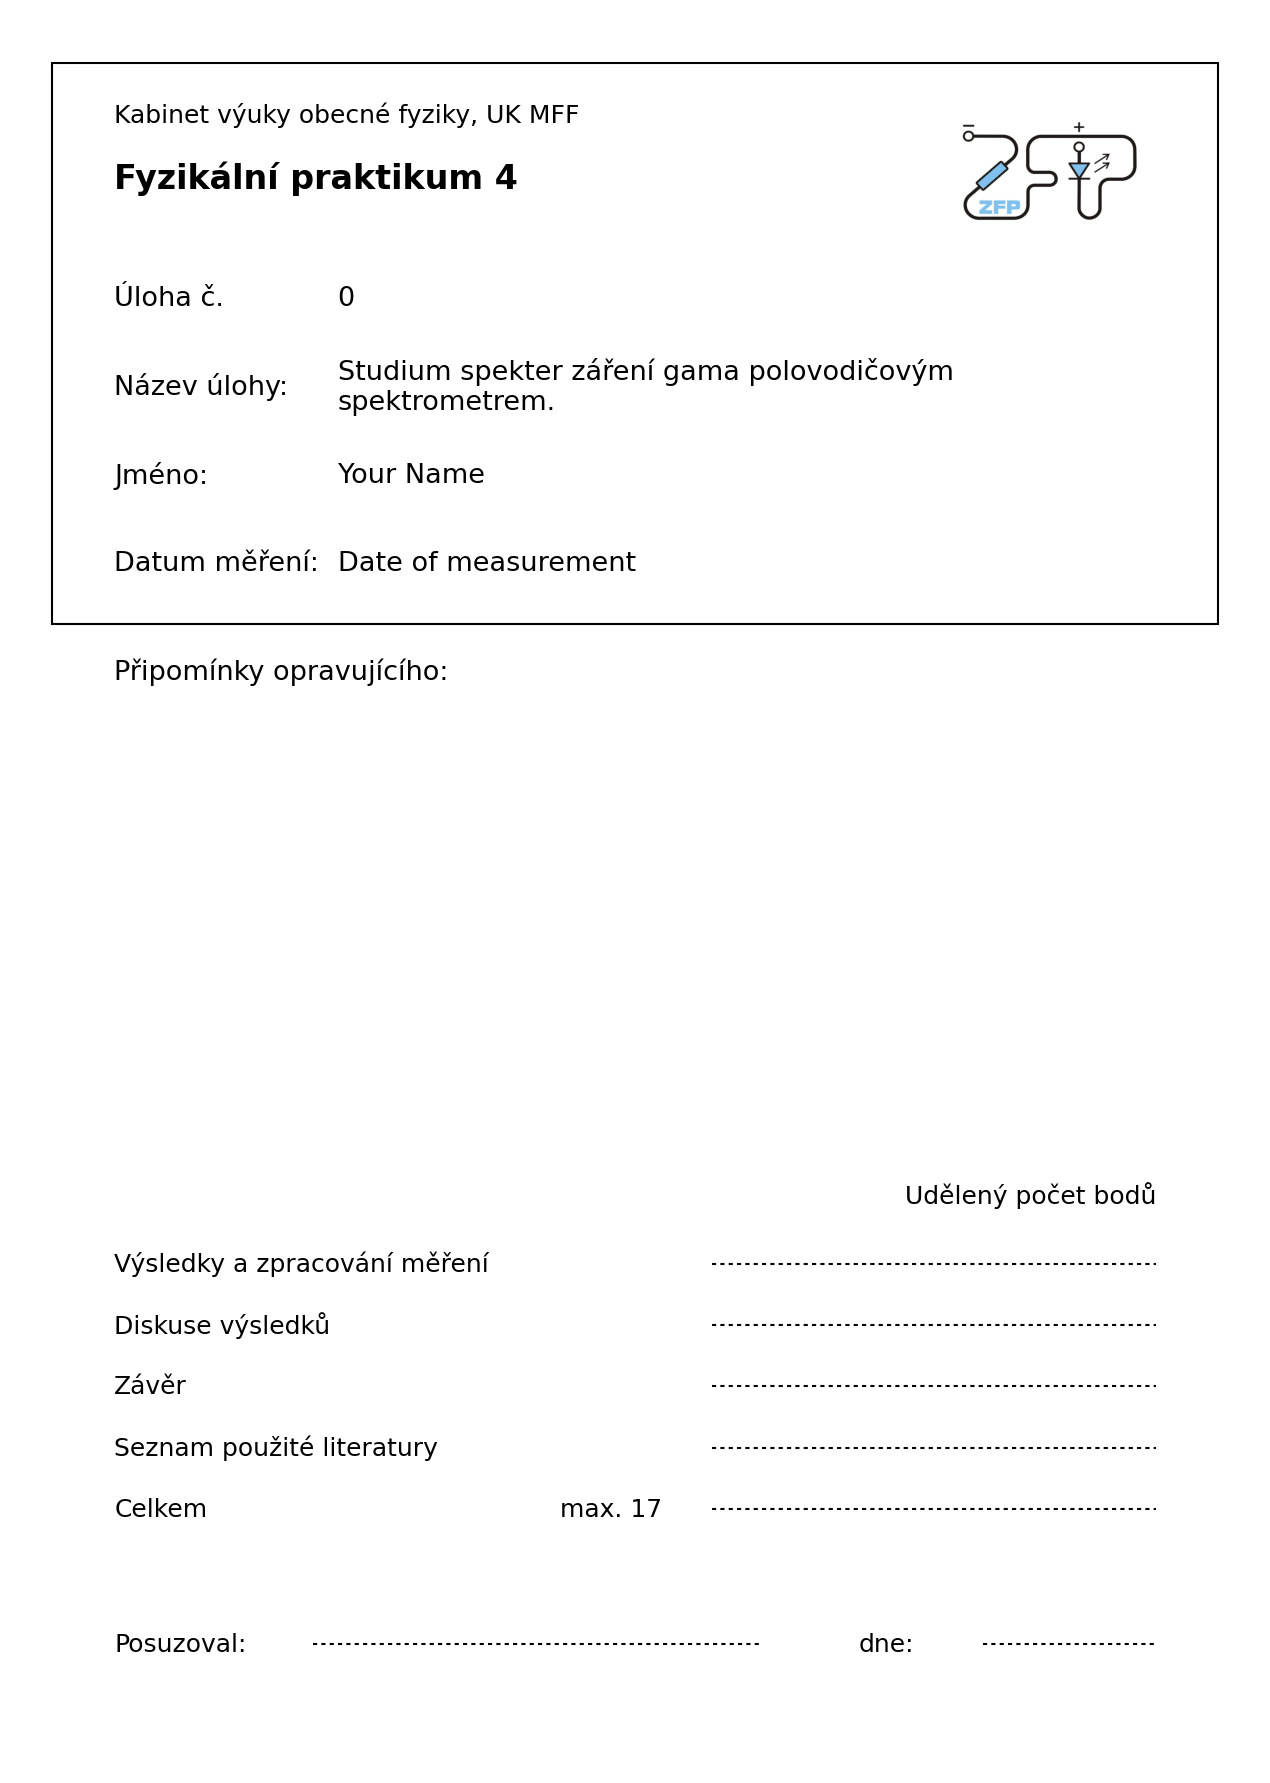

In [1]:
# TODO: Replace the string "Your Name" and "Date of measurement" with the appropriate values.

from header import header
_ = header(student="Your Name", date="Date of measurement", task_no=0)

# Studium spekter $\gamma$-záření polovodičovým spektrometrem

# Pracovní úkoly  
 1. Proveďte kalibraci spektrometru pomocí preparátu obsahujícího $^{226}\mathrm{Ra}$.
 2. Změřte spektrum $\gamma$ zářiče $^{137}\mathrm{Cs}$. Analyzujte jej.
 3. Změřte spektrum $\gamma$-záření aktivované kuchyňské soli. Analyzujte jej.
 4. Vysvětlete mechanizmy vzniku pozorovaných objektů v aparaturních spektrech.
 5. Porovnejte změřené energie všech pozorovaných objektů ve spektrech s tabulkovými nebo teoretickými hodnotami.
 6. Proveďte fit závislosti šířky píku na jejich energii.

# Úvod

## Princip spektrometru
V aktivní oblasti detektoru předává nabitá částice svou energii $T$, čímž vzniká $n = T/\omega$ párů elektron–díra. Sejmutý náboj $q$ vyvolá na elektrodách napěťový puls
$$
V = \frac{q}{C} = \alpha \frac{T}{\omega C},
$$
jehož amplituda je přímo úměrná energii částice. Pulsy jsou zesíleny a převedeny v ADC na číselnou hodnotu, která se ukládá do příslušného kanálu histogramu. Takto vzniká aparáturní spektrum, v němž poloha píků odpovídá energii registrovaných částic.

Šířku píku ovlivňuje několik příspěvků: elektronický šum $\sigma_\text{noise}$, statistické kolísání počtu vytvořených párů $\sigma_\text{stat}$ a nehomogenita sběru náboje $\sigma_\text{nonuni}$. Celkově ji popisuje vztah
$$
\sigma^2 = \sigma_\text{noise}^2 + \sigma_\text{stat,0}^2 T + \sigma_\text{nonuni,0}^2 T^2.
$$
V praxi se používá parametr FWHM, jehož závislost na energii lze psát jako
$$
\text{FWHM}(T) = \sqrt{a+bT+cT^2}.
$$

## Odezva spektrometru

### Hlavní procesy
Při **fotoefektu** je foton absorbován elektronovým obalem, přičemž elektron získává kinetickou energii $T_e = E_0 - I_i$. Pro vnější hladiny el. obalu je $I_i \ll E_0$, takže $T_e \approx E_0$, a ve spektru se objeví pík plné absorpce (FEP). Pro vnitřní hladiny se $T_e$ od $E_0$ liší, ale elektronový obal se deexcituje vyzářením rentgenovského záření, které se absorbuje fotoefektem již v tenké vrstvě detektoru. Celková energie elektronů je tedy opět $\approx E_0$ a událost přispívá do FEP.

Při **Comptonově rozptylu** je energie předána pouze částečně. Označme klidovou energii elektronu jako $\varepsilon = m_e c^2 \approx 511\ \text{keV}$. Energie rozptýleného fotonu na úhel $\vartheta$ je
$$
E(\vartheta) = \frac{E_0 \varepsilon}{\varepsilon + E_0(1-\cos \vartheta)},
$$
a odpovídající elektrony mají spojité spektrum do maximální energie
$$
T_e^\text{max} = \frac{2E_0^2}{\varepsilon+2E_0},
$$
což určuje tzv. Comptonovu hranu.

Při **tvorbě párů** (pro $E_0 > 2\varepsilon$) vzniká elektron a pozitron s celkovou energií $T = E_0 - 2\varepsilon$. Pozitron po zbrzdění anihiluje na dvě kvanta s energiemi 511 keV. Jestliže jsou obě absorbována, dostáváme opět pík plné absorpce; pokud unikne jedno či obě kvanta, objeví se pík jednoho (SEP) nebo dvou úniků (DEP).

### Druhotné efekty
Spektrum dále ovlivňují vícenásobné interakce, při nichž foton po Comptonově rozptylu znovu interaguje a předá dodatečnou energii. Hraniční energie při dvojnásobném rozptylu je $\frac{4E_0^2}{\varepsilon+4E_0}$. Pokud k interakcím dochází v pasivních částech detektoru, mohou se ve spektru projevit píky zpětného rozptylu na energii $E(180^\circ)$ či anihilační pík na 511 keV. Spektrometr rovněž registruje přírodní γ-záření z okolí, typicky z radionuklidů $^{40}\mathrm{K}$ nebo rozpadových řad $\mathrm{U}$ a $\mathrm{Th}$. V případě zdrojů s vícero γ-přechody mohou nastat i sumační píky, které vznikají současnou registrací dvou fotonů a leží na energii rovné jejich součtu.

In [2]:
# during Theory it might be benefitial to create functions computing energies of object we expect to measure later
ME = 510.99895  # m_e c^2 in keV

def compton_edge(E):
    """
    All functions below have structure similar to the following:

    Returns energy of Compton's edge for initial gamma with energy E.

    Parameters: E : float or array-like of FEP(s) in keV.

    Returns: CE : float or ndarray of energies of Compton's edges in keV.
    """
    E = np.asarray(E, dtype=float)
    Eprime = E / (1.0 + 2.0*E/ME)   # energie of gamma after 180° scattering
    CE = E - Eprime
    return CE if CE.shape else float(CE)

def backscatter_edge(E):
    E = np.asarray(E, dtype=float)
    Eprime = E / (1.0 + 2.0*E/ME)
    return Eprime if Eprime.shape else float(Eprime)

def double_compton(E):
    E = np.asarray(E, dtype=float)
    DE = 4*E**2 / (ME + 4*E)
    return DE if DE.shape else float(DE)

def SEP(E):
    E = np.asarray(E, dtype=float)
    SEP = E - ME
    return SEP if SEP.shape else float(SEP)

def DEP(E):
    E = np.asarray(E, dtype=float)
    DEP = E - 2*ME
    return DEP if DEP.shape else float(DEP)


In [3]:
# and also a function to calculate uncertainty of peak's energy from FWHM and NetArea
def StatUncE(FWHM, NetArea):
    uncE = FWHM / np.sqrt(8.*np.log(2)) / np.sqrt(NetArea)
    return uncE

# Postup měření

Nakalibrujeme spektrometr pomocí spektra nabraného s preparátem obsahujícím $^{226}\mathrm{Ra}$. Dále naměříme spektrum zářiče $^{137}\mathrm{Cs}$ (asi 10 minut) a spektrum aktivované kuchyňské soli (co nejdelší čas). Při každém měření označíme relevantní píky a uložíme si výpis s výsledky jejich fitů. Polohy hran a hraničních energií odečteme "ručně", jejich nejistoty odhadneme (na základě šířky binu apod.).

# Výsledky měření

$\color{red}{\textbf{Úkol:}}$ Proveďte kalibraci spektrometru pomocí preparátu obsahujícího $^{226}\mathrm{Ra}$. Použijte tabelované energie pěti singletních, lokálně nejintenzivnějších píků. Výpočet kalibrace provádí spektrometrický software, uvažuje lineární (a kvadratický) přepočet mezi kanálem a energií. Diskutujte výslednou kalibraci, systematickou nejistotu určování energií píků z kalibrace odhadněte pomocí dalších intenzivních singletních píků ve spektru, případně píku přirozeného pozadí $^{40}\mathrm{K}$.

$\color{red}{\textbf{Řešení:}}$  
Ke kalibraci jsme použili zářič od A4. Izotop $^{226}\mathrm{Ra}$ je členem rozpadové řadu $^{238}\mathrm{U}$. Většina námi pozorovaných $\gamma$ linek pochází z izotopů s $A=214$, jejich tabelované energie jsme získaly z databáze ENSDF [1]. Z níže uvedeného grafu a z koeficientů uvedených ve .Spe souboru lze vyvodit, že lineární kalibrace je dostačující. Odchylky měřených energií od tabelovaných se pohybují mezi -0.05 a 0.05 keV bez očividné závislosti na energii. Proto konzervativně odhadneme systematickou nejistotu energie na 0.05 keV.

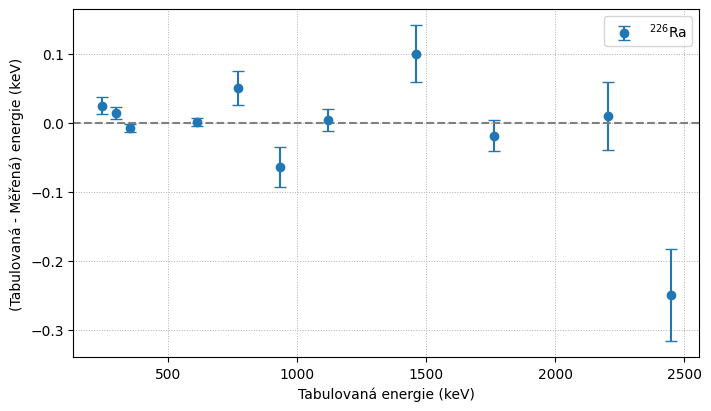

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# From the SW output (on screen or .Rpt file):
#  CENTROID -> exp_E[keV]
#  NET -> NetArea
#  +/- -> unc_NetArea

# Elements of the inner list are:
#   ["ID", tab_E(keV), exp_E(keV), FWHM (keV), NetArea, unc_NetArea]

# The most intense lines are as follows, everyone should use the 5 calibration ones and surely see and use at least 3 others. Depends on particular source used for the calibration.
# 226Ra α decay: 186.211 13 ; 
# 214Pb β− decay: 241.995(4) ; 295.224(2) ; 351.9320(21) ; 785.96(9) ; 839.06(9) 
# 214Bi β− decay: 609.321(7) ; 768.360(7) ; 934.056(8) ; 1120.294(6) ; 1238.122(10) ; 1764.491(14) ; 2204.10(4) ; 2447.69(3)
# 40K ε decay: 1460.820(5)

calibration_peaks = [
    [1, 351.932, 351.94, 1.06, 5632, 407],
    [2, 609.321, 609.32, 1.24, 7488, 188],
    [3, 1120.294, 1120.29, 1.54, 1566, 130],
    [4, 1764.491, 1764.51, 1.82, 1191, 78],
    [5, 2204.10, 2204.09, 2.04, 314, 59],
]

other_peaks = [
    [1, 241.995, 241.97, 0.99, 1059, 175],
    [2, 295.224, 295.21, 0.99, 2347, 129],
    [3, 768.360, 768.31, 1.31, 518, 128],
    [4, 934.056, 934.12, 1.45, 449, 137],
    # [4, 1238.122, 1238.16, 3.23, 8871, 156],
    [5, 1460.82, 1460.72, 1.55, 252, 67],
    [6, 2447.69, 2447.94, 1.48, 89, 24],
]

# construct DataFrame
cols = ["ID", "tab_E[keV]", "exp_E[keV]", "FWHM (keV)", "NetArea", "unc_NetArea"]

# define DataFrame
df1 = pd.DataFrame(calibration_peaks, columns=cols)
df2 = pd.DataFrame(other_peaks, columns=cols)

# unite the data
df = pd.concat([df1, df2], ignore_index=True)

# construct the differences between tabulated and calibrated energies
df["diff"] = df["tab_E[keV]"] - df["exp_E[keV]"]
df["diff_unc"] = df["FWHM (keV)"] / np.sqrt(8.*np.log(2)) / np.sqrt(df["NetArea"])

# create the plot
# plt.close('all')  # kill any stale canvases

fig, ax = plt.subplots(figsize=(7,4), constrained_layout=True)  # avoid tight_layout with ipympl
ax.errorbar(df["tab_E[keV]"], df["diff"],
            yerr=df["diff_unc"], fmt="o", capsize=4, label=r"$^{226}$Ra")

ax.axhline(0, color="gray", linestyle="--")

ax.set_xlabel("Tabulovaná energie (keV)")
ax.set_ylabel("(Tabulovaná - Měřená) energie (keV)")

ax.legend()
ax.grid(True, which="both", linestyle=":", linewidth=0.7)

# ax.set_ylim(-0.05, 0.35)

fig.canvas.draw_idle()

$\color{red}{\textbf{Úkol:}}$ Změřte spektrum $\gamma$ zářiče $^{137}\mathrm{Cs}$. Analyzujte jej.  
Z aparaturního spektra určete:  
i)   energii $\gamma$-záření (FEP),  
ii)  polohu Comptonovy hrany,  
iii) hraniční energii dvojného Comptonova rozptylu,  
iv)  polohu hrany zpětného rozptylu,  
v)   energie $\gamma$-záření přirozeného pozadí a identifikujte zdroje.

$\color{red}{\textbf{Řešení:}}$ 
1) Připravíme si ?funkci? pro čtení .Spe souborů.

In [5]:
def read_spe_with_cal(filename, verbose=True):
    """
    This reads the ORTEC/MAESTRO .Spe file.
    Returns: Energies [keV] (or Channels when $ENER_FIT is missing) and Counts.
    """
    counts = []
    a = b = None
    start_chan = end_chan = None
    in_data = False

    # files might have different newline characters/encoding; latin-1 is usually the safe choice
    with open(filename, "r", encoding="latin-1", errors="replace") as f:
        lines = f.readlines()

    for i, raw_line in enumerate(lines):
        line = raw_line.strip()

        # catch the calibration coefficients using $ENER_FIT
        if line.startswith("$ENER_FIT:"):
            if i + 1 < len(lines):
                a, b = map(float, lines[i + 1].split())
                if verbose:
                    print(f"[ENER_FIT] a={a}, b={b}")
            continue

        # catch the start of the data using $DATA
        if line.startswith("$DATA:"):
            in_data = True
            continue

        # read the data
        if in_data:
            if line.startswith("$"):  # end of data
                in_data = False
                continue
            parts = line.split()
            if start_chan is None and len(parts) == 2:
                start_chan, end_chan = map(int, parts)
                if verbose:
                    print(f"[DATA range] {start_chan}..{end_chan}")
                continue
            # individual counts
            if len(parts) == 1 and parts[0].isdigit():
                counts.append(int(parts[0]))
            # empty/other lines are ignored

    if start_chan is None or end_chan is None:
        raise ValueError("V $DATA: sekci nebyl nalezen rozsah kanálů (první řádek po $DATA:).")

    channels = np.arange(start_chan, end_chan + 1, dtype=float)
    counts = np.asarray(counts, dtype=float)

    if len(counts) != len(channels):
        raise ValueError(f"Počet načtených hodnot ({len(counts)}) neodpovídá počtu kanálů ({len(channels)}).")

    # Calculate energies from channels using calibration coefficients (if available from $ENER_FIT)
    if a is not None and b is not None:
        energies = a + b * channels
    else:
        energies = channels  # no calibration -> use channels

    return energies, counts

2) Načteme si spektrum cesia a vykreslíme ho do grafu.

[DATA range] 0..8191
[ENER_FIT] a=-0.195181, b=0.42588
Energie (keV): [ 9.600059 10.025939 10.451819 10.877699 11.303579 11.729459 12.155339
 12.581219 13.007099 13.432979]
Četnost: [  81.  427. 2074. 9281.  739.  570.  657.  861.  936. 1118.]


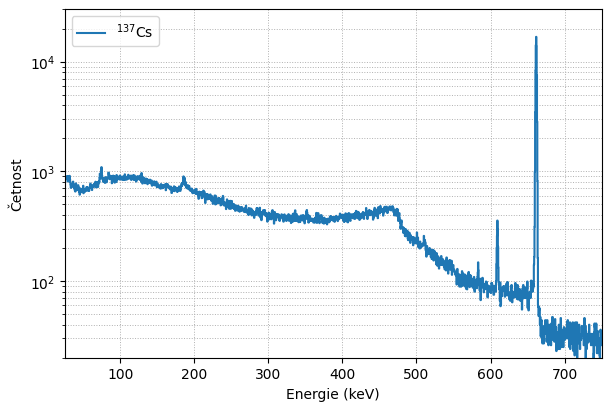

In [6]:
energies, counts = read_spe_with_cal("example_Cs.Spe", True) # change second argument to False to disable debug output

# additional output for debuging
print("Energie (keV):", energies[23:33])
print("Četnost:", counts[23:33])

# create the plot
plt.close('all')  # kill any stale canvases

fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)  # avoid tight_layout with ipympl

ax.step(energies, counts, where="mid", label="$^{137}$Cs")
ax.set_xlabel("Energie (keV)" if np.any(energies != np.arange(len(energies))) else "Kanál")
ax.set_ylabel("Četnost")
ax.grid(True, which="both", linestyle=":", linewidth=0.7)
ax.legend()

# log scale is useful when you want to see the whole spectrum
ax.set_yscale("log")

# set limits AFTER plotting, below the Cs part of the whole spectrum
ax.set_xlim(25, 750)
ax.set_ylim(2e1, 3e4)

# example of zoom (on the Compton edge)
# ax.set_xlim(450, 550)
# ax.set_ylim(2e1, 5e2)

fig.canvas.draw_idle()  # gentle redraw for ipympl

3) Do spektra bychom měli vyznačit objekty i) - v), níže pak jejich energie porovnat s tabelovanými (teoretickými).

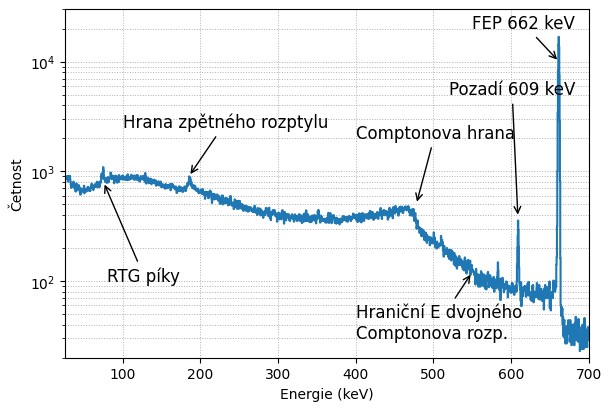

In [7]:
energies, counts = read_spe_with_cal("example_Cs.Spe",False)

plt.close('all')  # kill any stale canvases

# create the plot
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)

ax.step(energies, counts, where="mid")

ax.set_xlabel("Energie (keV)" if np.any(energies != np.arange(len(energies))) else "Kanál")
ax.set_ylabel("Četnost")
ax.set_yscale("log")
ax.grid(True, which="both", linestyle=":", linewidth=0.7)

ax.set_xlim(25, 700)      # custom range for X axis
ax.set_ylim(2e1, 3e4)     # custom range for Y axis

ax.annotate("FEP 662 keV",
            xy=(662, 1e4),
            xytext=(550, 2e4),
            arrowprops=dict(arrowstyle="->", color="black"),
            fontsize=12, color="black")

ax.annotate("Comptonova hrana",
            xy=(478, 5e2),
            xytext=(400, 2000),
            arrowprops=dict(arrowstyle="->", color="black"),
            fontsize=12, color="black")

ax.annotate("Hrana zpětného rozptylu",
            xy=(185, 9e2),
            xytext=(100, 2500),
            arrowprops=dict(arrowstyle="->", color="black"),
            fontsize=12, color="black")

ax.annotate("Hraniční E dvojného\nComptonova rozp.",
            xy=(550, 120),
            xytext=(400, 30),
            arrowprops=dict(arrowstyle="->", color="black"),
            fontsize=12, color="black")

ax.annotate("Pozadí 609 keV",
            xy=(609, 380),
            xytext=(520, 5e3),
            arrowprops=dict(arrowstyle="->", color="black"),
            fontsize=12, color="black")

ax.annotate("RTG píky",
            xy=(75, 8e2),
            xytext=(80, 1e2),
            arrowprops=dict(arrowstyle="->", color="black"),
            fontsize=12, color="black")

fig.canvas.draw_idle()  # gentle redraw for ipympl

4) Vytvořme tabulku objektů pozorovaných ve spektru $^{137}\mathrm{Cs}$, porovnejme jejich energie s tabelovanými/teoretickými.

In [8]:
# Hardcode the data

Cs_data = [
    ["FEP", 661.657, 0.003, 661.64, np.sqrt(np.pow(StatUncE(1.63, 69072),2) + np.pow(0.05,2))],
    ["Comptonova hrana", compton_edge(661.657), 0.003, 477., 3.],
    ["Hraniční E dvojného CR", double_compton(661.657), 0.003, 558., 5.],
    ["Hrana zpětného rozptylu", backscatter_edge(661.657), 0.003, 184., 2.],
    ["Pozadí Bi-214", 609.321, 0.007, 609.31, np.sqrt(np.pow(StatUncE(1.46,721),2) + np.pow(0.05,2))],
    ["Pozadí K-40", 1460.820, 0.005, 1460.72, np.sqrt(np.pow(StatUncE(1.84,346),2) + np.pow(0.05,2))]
]

# Create DataFrame
Cs_df = pd.DataFrame(Cs_data, columns=["Object", "tab_E[keV]", "unc_tab_E[keV]", "exp_E[keV]", "unc_exp_E[keV]"])

# Print DataFrame out
# Cs_df.round(3)
# or
print(Cs_df.round(3).to_string(index=False, col_space=10, header=["Objekt", "Tab./Teor. E (keV)", "Nej. Tab./Teor. E (keV)", "Měřená E (keV)", "Nej. měřené E (keV)"]))


                 Objekt Tab./Teor. E (keV) Nej. Tab./Teor. E (keV) Měřená E (keV) Nej. měřené E (keV)
                    FEP            661.657                   0.003         661.64               0.050
       Comptonova hrana            477.334                   0.003         477.00               3.000
 Hraniční E dvojného CR            554.581                   0.003         558.00               5.000
Hrana zpětného rozptylu            184.323                   0.003         184.00               2.000
          Pozadí Bi-214            609.321                   0.007         609.31               0.055
            Pozadí K-40           1460.820                   0.005        1460.72               0.065


5) Vizualizujme si výsledky.

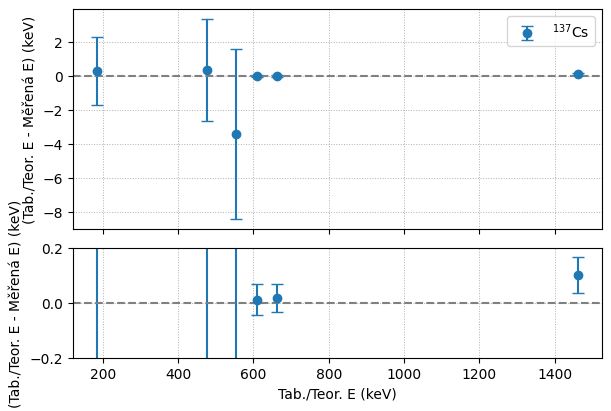

In [9]:
# construct the differences between tabulated and calibrated energies
Cs_df["diff"] = Cs_df["tab_E[keV]"] - Cs_df["exp_E[keV]"]
Cs_df["diff_unc"] = np.sqrt( np.pow(Cs_df["unc_tab_E[keV]"],2) + np.pow(Cs_df["unc_exp_E[keV]"],2) )

plt.close('all')  # kill any stale canvases

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,4),
                               gridspec_kw={'height_ratios': [2,1]}, constrained_layout=True)

# Horní panel – celý rozsah
ax1.errorbar(Cs_df["tab_E[keV]"], Cs_df["diff"],
             yerr=Cs_df["diff_unc"], fmt="o", capsize=4, label="$^{137}$Cs")
ax1.axhline(0, color="gray", linestyle="--")
ax1.set_ylabel("(Tab./Teor. E - Měřená E) (keV)")
ax1.legend()
ax1.grid(True, which="both", linestyle=":", linewidth=0.7)

# Dolní panel – zoom na ±0.1 keV kolem nuly (uprav dle potřeby)
ax2.errorbar(Cs_df["tab_E[keV]"], Cs_df["diff"],
             yerr=Cs_df["diff_unc"], fmt="o", capsize=4)
ax2.axhline(0, color="gray", linestyle="--")
ax2.set_xlabel("Tab./Teor. E (keV)")
ax2.set_ylabel("(Tab./Teor. E - Měřená E) (keV)")
ax2.set_ylim(-.2, .2)   # zoom kolem nuly
ax2.grid(True, which="both", linestyle=":", linewidth=0.7)

fig.canvas.draw_idle()  # gentle redraw for ipympl

$\color{red}{\textbf{Úkol:}}$ Změřte spektrum $\gamma$-záření aktivované kuchyňské soli. Analyzujte jej.  
Z aparaturního spektra určete:  
i)   energie $\gamma$-záření vzorku, tzn. energie FEP píků,  
ii)  polohy Comptonových hran příslušných k nejintenzivnějším FEP píkům,  
iii) energie viditelných únikových píků,  
iv)  energii anihilačního píku,  
v)   energie píků pozadí a identifikujte zdroje.

$\color{red}{\textbf{Řešení:}}$ 
Při ozařování kuchyňské soli dochází na stabilních izotopech sodíku a chlóru k radiačnímu záchytu neutronů. Vznikají izotopy s o jednotku vyšším nukleonovým číslem, které jsou nestabilní a přeměňují se $\beta^-$ rozpadem na stabilní izotopy hořčíku, resp. argonu. Při těchto $\beta^-$ přeměnách mohou dceřinná jádra vznikat ve vzbuzených stavech a deexcitovat se emisí $\gamma$. Technicky vzato tedy námi pozorované píky přísluší např. $^{24}\mathrm{Mg}$ a dle tohoto volíme zdroj tabelovaných energií [2].

1) Načteme si spektrum soli a vykreslíme ho do grafu. Funkci již máme hotovou.

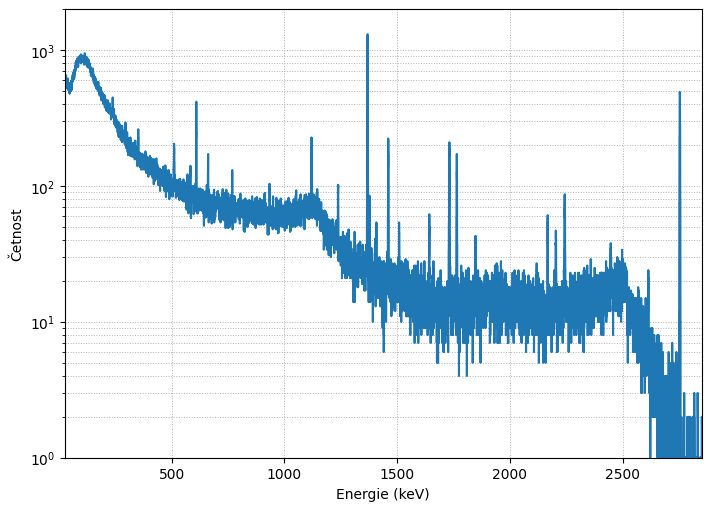

In [10]:
import matplotlib.pyplot as plt
energies, counts = read_spe_with_cal("example_NaCl.Spe", False)

plt.close('all')  # kill any stale canvases

# create the plot
fig, ax = plt.subplots(figsize=(7,5), constrained_layout=True)

ax.step(energies, counts, where="mid")

ax.set_xlabel("Energie (keV)" if np.any(energies != np.arange(len(energies))) else "Kanál")
ax.set_ylabel("Četnost")
ax.set_yscale("log")
ax.grid(True, which="both", linestyle=":", linewidth=0.7)

ax.set_xlim(25, 2850)     # custom range for X axis
ax.set_ylim(1e0, 2e3)     # custom range for Y axis

fig.canvas.draw_idle()  # gentle redraw for ipympl

2) Do spektra vyznačíme objekty i) - v).

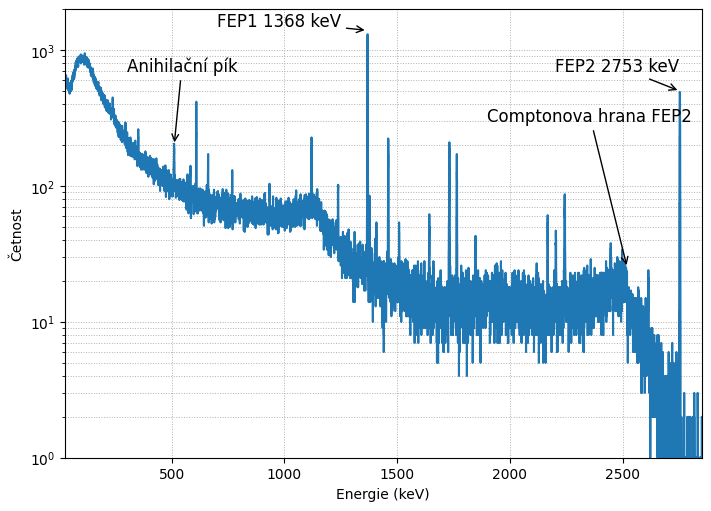

In [11]:
import matplotlib.pyplot as plt
energies, counts = read_spe_with_cal("example_NaCl.Spe", False)

plt.close('all')  # kill any stale canvases

# create the plot
fig, ax = plt.subplots(figsize=(7,5), constrained_layout=True)

ax.step(energies, counts, where="mid")

ax.set_xlabel("Energie (keV)" if np.any(energies != np.arange(len(energies))) else "Kanál")
ax.set_ylabel("Četnost")
ax.set_yscale("log")
ax.grid(True, which="both", linestyle=":", linewidth=0.7)

ax.set_xlim(25, 2850)     # custom range for X axis
ax.set_ylim(1e0, 2e3)     # custom range for Y axis

ax.annotate("FEP2 2753 keV",
            xy=(2754, 5e2),
            xytext=(22e2, 7e2),
            arrowprops=dict(arrowstyle="->", color="black"),
            fontsize=12, color="black")

ax.annotate("Comptonova hrana FEP2",
            xy=(2520, 25),
            xytext=(19e2, 3e2),
            arrowprops=dict(arrowstyle="->", color="black"),
            fontsize=12, color="black")

ax.annotate("FEP1 1368 keV",
            xy=(1368, 14e2),
            xytext=(7e2, 15e2),
            arrowprops=dict(arrowstyle="->", color="black"),
            fontsize=12, color="black")

ax.annotate("Anihilační pík",
            xy=(511, 2e2),
            xytext=(3e2, 7e2),
            arrowprops=dict(arrowstyle="->", color="black"),
            fontsize=12, color="black")

fig.canvas.draw_idle()  # gentle redraw for ipympl

3) Vytvoříme tabulku objektů pozorovaných ve spektru soli a porovnáme jejich energie s tabelovanými/teoretickými.

In [12]:
# Hardcode the data

sul_data = [
    ["FEP2", 2754.008, 0.011, 2753.93, np.sqrt(np.pow(StatUncE(2.61, 3102),2) + np.pow(0.05,2))],
    ["Comptonova hrana FEP2", compton_edge(2754.008), 0.011, 2520., 5.],
    ["SEP2", SEP(2754.008), 0.011, 2242.93, np.sqrt(np.pow(StatUncE(2.97, 510),2) + np.pow(0.05,2))],
    ["DEP2", DEP(2754.008), 0.011, 1731.95, np.sqrt(np.pow(StatUncE(2.50, 1371),2) + np.pow(0.05,2))],
    ["FEP1", 1368.625, 0.005, 1368.56, np.sqrt(np.pow(StatUncE(2.02, 7245),2) + np.pow(0.05,2))],
    ["Anihilační pík", 510.99895, 0.0, 510.98, np.sqrt(np.pow(StatUncE(2.35, 750),2) + np.pow(0.05,2))],
    ["DEP1", DEP(1368.625), 0.005, 351.99, np.sqrt(np.pow(StatUncE(1.50, 158),2) + np.pow(0.05,2))],
    ["pozadí Pb-214 ", 351.9320, 0.0021, 351.99, np.sqrt(np.pow(StatUncE(1.50, 158),2) + np.pow(0.05,2))],
    ["Hrana zpětného rozptylu", backscatter_edge(1368.625), 0.003, 184., 2.],
    ["Hrana zpětného rozptylu", backscatter_edge(2754.008), 0.003, 184., 2.],
]

# Create DataFrame
sul_df = pd.DataFrame(sul_data, columns=["Object", "tab_E[keV]", "unc_tab_E[keV]", "exp_E[keV]", "unc_exp_E[keV]"])

# Print DataFrame out
print(sul_df.round(3).to_string(index=False, col_space=10, header=["Objekt", "Tab./Teor. E (keV)", "Nej. Tab./Teor. E (keV)", "Měřená E (keV)", "Nej. měřené E (keV)"]))

                 Objekt Tab./Teor. E (keV) Nej. Tab./Teor. E (keV) Měřená E (keV) Nej. měřené E (keV)
                   FEP2           2754.008                   0.011        2753.93               0.054
  Comptonova hrana FEP2           2520.200                   0.011        2520.00               5.000
                   SEP2           2243.009                   0.011        2242.93               0.075
                   DEP2           1732.010                   0.011        1731.95               0.058
                   FEP1           1368.625                   0.005        1368.56               0.051
         Anihilační pík            510.999                   0.000         510.98               0.062
                   DEP1            346.627                   0.005         351.99               0.071
         pozadí Pb-214             351.932                   0.002         351.99               0.071
Hrana zpětného rozptylu            215.306                   0.003         184.00 

4) Vizualizujme si výsledky.

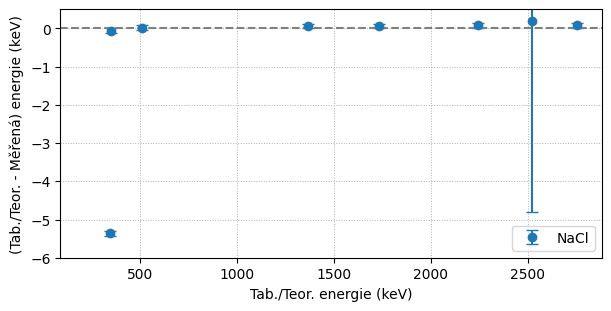

In [13]:
# construct the differences between tabulated and calibrated energies
sul_df["diff"] = sul_df["tab_E[keV]"] - sul_df["exp_E[keV]"]
sul_df["diff_unc"] = np.sqrt( np.pow(sul_df["unc_tab_E[keV]"],2) + np.pow(sul_df["unc_exp_E[keV]"],2) )

plt.close('all')  # kill any stale canvases

# Plot
fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)

ax.errorbar(sul_df["tab_E[keV]"], sul_df["diff"],
            yerr=sul_df["diff_unc"], fmt="o", capsize=4, label="NaCl")

ax.axhline(0, color="gray", linestyle="--")

ax.set_xlabel("Tab./Teor. energie (keV)")
ax.set_ylabel("(Tab./Teor. - Měřená) energie (keV)")

ax.legend()
ax.grid(True, which="both", linestyle=":", linewidth=0.7)

ax.set_ylim(-6, 0.5)

fig.canvas.draw_idle()  # gentle redraw for ipympl


$\color{red}{\textbf{Úkol:}}$ Vysvětlete mechanizmy vzniku pozorovaných objektů v aparaturních spektrech.  

$\color{red}{\textbf{Řešení:}}$ 
Je možné/žádoucí, že tohle je dostatečně popsáno v Úvodu.

$\color{red}{\textbf{Úkol:}}$ Proveďte fit závislosti šířky píku na jejich energii.

$\color{red}{\textbf{Řešení:}}$  
1) Napišme si funkci pro čtení .Rpt souborů.

In [14]:
import pandas as pd

def read_roi_report(path):
    """
    Načte textový report ROI (viz příklad v zadání) a vrátí DataFrame
    se sloupci:
        ROI, E_centroid_keV, FWHM_keV, NET_counts, u_NET_counts,
        range_lo_keV, range_hi_keV
    """
    rows = []
    in_roi = False

    with open(path, "r", encoding="latin-1", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue

            # začátek tabulky s ROI
            if s.startswith("ROI#"):
                in_roi = True
                continue

            if not in_roi:
                continue

            # typická ROI řádka začíná číslem a má aspoň ~9–10 tokenů
            parts = s.split()
            if not parts or not parts[0].isdigit():
                continue
            if len(parts) < 9:
                continue

            try:
                roi_idx         = int(parts[0])
                range_lo_keV    = float(parts[1])
                range_hi_keV    = float(parts[2])
                gross_counts    = int(parts[3])              # (nepotřebujeme, ale může se hodit)
                net_counts      = int(parts[4])              # NET
                u_net_counts    = int(parts[5])              # sloupec "+/-"
                centroid_keV    = float(parts[6])            # energie (centroid)
                fwhm_keV        = float(parts[7])            # FWHM
                # parts[8] je FW(1/5)M – ignorujeme
            except ValueError:
                # řádka nesedí formátu – přeskoč
                continue

            rows.append({
                "ROI": roi_idx,
                "E_keV": centroid_keV,
                "FWHM_keV": fwhm_keV,
                "NET_counts": net_counts,
                "u_NET_counts": u_net_counts,
                "range_lo_keV": range_lo_keV,
                "range_hi_keV": range_hi_keV,
            })

    if not rows:
        raise ValueError("V souboru se nenašly žádné ROI řádky.")

    df = pd.DataFrame(rows).sort_values("ROI").reset_index(drop=True)
    return df


2) Načtěme naše .Rpt soubory. Jednotlivé DataFrame spojme do jednoho.

In [15]:
# read the .Rpt files using the above function
peaks_Ra = read_roi_report("Ra226_24Sep2025.Rpt")
peaks_Cs = read_roi_report("Cs137_24Sep2025.Rpt")
peaks_Na = read_roi_report("NaCl_24Sep2025.Rpt")

# debug line to print out the result of reading
# print(peaks_Cs.to_string(index=False))

# unite the peak data
df_peaks = pd.concat([peaks_Ra, peaks_Cs, peaks_Na], ignore_index=True)

# create uncertainties
df_peaks["unc_FWHM_keV"] = df_peaks["FWHM_keV"] / np.sqrt(2*df_peaks["NET_counts"])

print(df_peaks.to_string(index=False))


 ROI   E_keV  FWHM_keV  NET_counts  u_NET_counts  range_lo_keV  range_hi_keV  unc_FWHM_keV
   1  241.97      0.99        1059           175        233.62        249.07      0.021512
   2  295.21      0.99        2347           129        288.91        301.11      0.014450
   3  351.94      1.06        5632           407        328.75        372.66      0.009988
   4  609.32      1.24        7488           188        594.23        627.16      0.010133
   5  768.31      1.31         518           128        752.38        777.19      0.040700
   6  934.12      1.45         449           137        919.49        950.80      0.048387
   7 1120.29      1.54        1566           130       1095.97       1128.09      0.027518
   8 1460.72      1.55         252            67       1452.61       1476.60      0.069042
   9 1764.51      1.82        1191            78       1744.61       1782.85      0.037291
  10 2204.09      2.04         314            59       2168.85       2238.41      0.081405

3) Nakreslíme závislost FWHM na energii a nafitujeme.

In [16]:
import matplotlib.pyplot as plt

def plot_with_fit(
    x, y, y_err,
    x_fit, y_fit, y_fit_lower, y_fit_upper,
    xlabel="", ylabel="",
    data_label="Data",
    fit_label="Fit",
    band_label="Fit uncertainty",
    data_color="black",
    fit_color="C3",
    ax=None,
    grid=True,
    show=True,
):
    """
    Vykreslí data s chybami + fit křivku + interval nejistoty (band).
    Vrací (fig, ax). Pokud ax není zadán, vytvoří nové fig/ax.

    Parametry:
      x, y, y_err ........... data a jejich nejistoty (stejné délky)
      x_fit, y_fit .......... vzorkování fitu
      y_fit_lower, y_fit_upper interval nejistoty pro fit
      xlabel, ylabel ........ popisky os
      *_label, *_color ...... popisky a barvy
      ax .................... existující axes (nepovinné)
      grid, show ............ zapnout mřížku a rovnou zobrazit
    """
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4), constrained_layout=True)
        created_fig = True
    else:
        fig = ax.figure

    # data
    ax.errorbar(x, y, yerr=y_err, fmt="o", capsize=4,
                label=data_label, color=data_color)

    # band + fit křivka
    band = ax.fill_between(x_fit, y_fit_lower, y_fit_upper,
                           color=fit_color, alpha=0.3, label=band_label)
    line, = ax.plot(x_fit, y_fit, "-", color=fit_color, lw=2, label=fit_label)

    # popisky, mřížka, legenda
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if grid:
        ax.grid(True, which="both", linestyle=":", linewidth=0.7)

    # posbírat a vypsat legendu (žádné hacky s tuple)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)

    if show and created_fig:
        fig.show()

    return fig, ax


 ROI   E_keV  FWHM_keV  NET_counts  u_NET_counts  range_lo_keV  range_hi_keV  unc_FWHM_keV
   1  241.97      0.99        1059           175        233.62        249.07      0.021512
   2  295.21      0.99        2347           129        288.91        301.11      0.014450
   3  351.94      1.06        5632           407        328.75        372.66      0.009988
   4  609.32      1.24        7488           188        594.23        627.16      0.010133
   5  768.31      1.31         518           128        752.38        777.19      0.040700
   6  934.12      1.45         449           137        919.49        950.80      0.048387
   7 1120.29      1.54        1566           130       1095.97       1128.09      0.027518
   9 1764.51      1.82        1191            78       1744.61       1782.85      0.037291
  10 2204.09      2.04         314            59       2168.85       2238.41      0.081405
  11 2447.94      1.48          89            24       2421.88       2478.02      0.110931

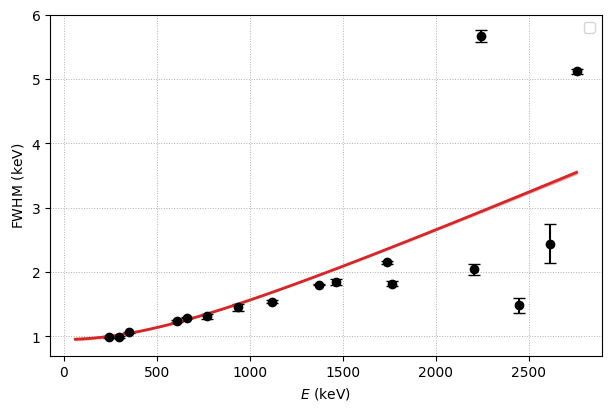

In [17]:
# Fitujme FWHM v závislosti na energii pomocí funkce: $FWHM(E) = \sqrt{a + b*E + c*E^2}$.
# Určíme parametry $a$, $b$ a $c$ a jejich nejistoty.
# Vykreslíme datové body a fitovanou funkci do stejného grafu.
# Při výpočtu nejistoty fitované funkce nezapomeňme zohlednit korelaci mezi fitovanými parametry!

from scipy.optimize import curve_fit
import uncertainties
import uncertainties.unumpy
import numpy as np

# Definujme mocninnou funkci.
def FWHM_law(E, a, b, c):
    return ((a + b*E + c*E**2)**0.5)

# Unless specified otherwise, fit will start from values 1 for all parameters.
# We know from Theory that some of our parameters are very different, so we better initialize them:
p0=[0.5, 1e-3, 1e-8]
# We need to omit some peaks from the fit - anihilation, SEP, ...
mask_drop = df_peaks["E_keV"].round().isin([62.,1461.,1463.,514.])
df_fit = df_peaks.loc[~mask_drop].copy()
print(df_fit.to_string(index=False))
# Nafitujme mocninnou funkci na naše data.
nom, cov = curve_fit(FWHM_law, df_fit['E_keV'], df_fit['FWHM_keV'], sigma=df_fit['unc_FWHM_keV'], absolute_sigma=True, p0=p0, bounds=(0, np.inf))

# Vypočítejme nejistoty fitovaných parametrů. Výsledky fitu vypišme.
a, b, c = uncertainties.correlated_values(nom, cov)
print(f'a = {a:.2uP} -> sqrt(a) = {a**0.5:.2uP}')
print(f'b = {b:.4uP}')
print(f'c = {c:.4uP}')
print(f'correlation submatrix:')
print(f'{cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1]):.3f} {cov[0, 2] / np.sqrt(cov[0, 0] * cov[2, 2]):.3f}')
print(f'      {cov[1, 2] / np.sqrt(cov[1, 1] * cov[2, 2]):.3f}')

# Vypočítejme fitovanou funkci na celočíselných hodnotách Z.
E_fit = np.linspace(df_peaks['E_keV'].min(), df_peaks['E_keV'].max(), 100)
FWHM_fit = FWHM_law(E_fit, a, b, c)
FWHM_fit_nom = uncertainties.unumpy.nominal_values(FWHM_fit)
FWHM_fit_std = uncertainties.unumpy.std_devs(FWHM_fit)

# Vykreslíme data a výslednou fitovanou funkci
plt.close('all')  # kill any stale canvases

fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
# fig, ax = plot_with_fit(x=df_peaks['E_keV'], y=df_peaks['FWHM_keV'], y_err=df_peaks['unc_FWHM_keV'],x_fit=E_fit, y_fit=FWHM_fit_nom, y_fit_lower=(FWHM_fit_nom - FWHM_fit_std), y_fit_upper=(FWHM_fit_nom + FWHM_fit_std), xlabel=r"$E\ \mathrm{(keV)}$", ylabel=r"$\mathrm{FWHM\ (keV)}$", data_label="", fit_label="", band_label="", ax=ax)
fig, ax = plot_with_fit(x=df_fit['E_keV'], y=df_fit['FWHM_keV'], y_err=df_fit['unc_FWHM_keV'],x_fit=E_fit, y_fit=FWHM_fit_nom, y_fit_lower=(FWHM_fit_nom - FWHM_fit_std), y_fit_upper=(FWHM_fit_nom + FWHM_fit_std), xlabel=r"$E\ \mathrm{(keV)}$", ylabel=r"$\mathrm{FWHM\ (keV)}$", data_label="", fit_label="", band_label="", ax=ax)


$\color{red}{\textbf{Úkol:}}$ Diskutuj měření a výsledky.

$\color{red}{\textbf{Řešení:}}$
# Diskuse

-> diskutujte zde <-

$\color{red}{\textbf{Úkol:}}$ Sepiš Závěr.

$\color{red}{\textbf{Řešení:}}$
# Závěr

-> závěrujte zde <-

# Literatura

[1] S. Zhu and E. A. McCutchan, Nuclear Data Sheets for A=214, Nucl. Data Sheets 175 (2021) 1–149. DOI: 10.1016/j.nds.2021.06.001 , dostupné na https://www.nndc.bnl.gov/ensdf/ .  
[2] M. S. Basunia and A. Chakraborty, Nuclear Data Sheets for A = 24, Nucl. Data Sheets 186 (2022) 3–262. DOI: 10.1016/j.nds.2022.11.002, dostupné na https://www.nndc.bnl.gov/ensdf/ .